In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import scanpy as sc
import copy
import sys
import glob

import seaborn as sns
%matplotlib inline

PROJ_DIR = "/home/icb/olle.holmberg/projects/LODE"

sys.path.insert(0, os.path.join(PROJ_DIR, 'feature_segmentation/utils'))

import plotting
plt.style.use('seaborn')

WORK_SPACE = "/storage/groups/ml01/workspace/olle.holmberg/LODE/feature_segmentation"
DATA_DIR = "/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler"

oct_meta_pd = pd.read_csv(os.path.join(DATA_DIR, "joint_export/oct_meta_information.csv"))

data_file = os.path.join(WORK_SPACE, "sequence_data/longitudinal_properties_naive.csv")
data_pd = pd.read_csv(data_file)
oct_meta_pd = pd.read_csv(os.path.join(WORK_SPACE, "sequence_data/oct_meta_information.csv"))

#### add patient id and lateraliy
data_pd["patient_id"] = data_pd.sequence.str.split("_", expand=True)[0]
data_pd["laterality"] = data_pd.sequence.str.split("_", expand=True)[1]

# add seg numpy a
data_pd["seg_record_1"] = data_pd.sequence + "_" + data_pd.study_date_1.str.replace("-", "") + ".npy"
data_pd["seg_record_3"] = data_pd.sequence + "_" + data_pd.study_date_3.str.replace("-", "") + ".npy"
data_pd["seg_record_12"] = data_pd.sequence + "_" + data_pd.study_date_12.str.replace("-", "") + ".npy"

## join study date one DICOM file

In [ ]:
study_date_1_dc = data_pd.sequence.str.split("_", expand=True)
study_date_1_dc = study_date_1_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_1_dc["study_date"] = data_pd["study_date_1"].str.replace("-", "")

study_date_1_dc.PATNR = study_date_1_dc.PATNR.astype(np.int64)
study_date_1_dc.study_date = study_date_1_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result1 = pd.merge(study_date_1_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result1 = result1.drop_duplicates(subset=keys)
result1 = result1.rename(columns={"oct_path": "study_date_1_dicom_path"})

result1["sequence"] = result1.PATNR.astype(str) + "_" + result1.laterality
##############

study_date_3_dc = data_pd.sequence.str.split("_", expand=True)
study_date_3_dc = study_date_3_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_3_dc["study_date"] = data_pd["study_date_3"].str.replace("-", "")

study_date_3_dc.PATNR = study_date_3_dc.PATNR.astype(np.int64)
study_date_3_dc.study_date = study_date_3_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result3 = pd.merge(study_date_3_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result3 = result3.drop_duplicates(subset=keys)
result3 = result3.rename(columns={"oct_path": "study_date_3_dicom_path"})

result3["sequence"] = result3.PATNR.astype(str) + "_" + result3.laterality
#############

study_date_12_dc = data_pd.sequence.str.split("_", expand=True)
study_date_12_dc = study_date_12_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_12_dc["study_date"] = data_pd["study_date_12"].str.replace("-", "")

study_date_12_dc.PATNR = study_date_12_dc.PATNR.astype(np.int64)
study_date_12_dc.study_date = study_date_12_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result12 = pd.merge(study_date_12_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result12 = result12.drop_duplicates(subset=keys)
result12 = result12.rename(columns={"oct_path": "study_date_12_dicom_path"})

result12["sequence"] = result12.PATNR.astype(str) + "_" + result12.laterality

data_pd = pd.merge(data_pd, result1[["study_date_1_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

data_pd = pd.merge(data_pd, result3[["study_date_3_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

data_pd = pd.merge(data_pd, result12[["study_date_12_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

In [ ]:
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    # sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

#### How many sequence are treated?

In [ ]:
print(f"number of treated sequences {data_pd.shape[0]}")

#### Insertion type distribution

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

### carried over time distribution

In [ ]:
plt.figure(figsize=(20,10))
month_6_carry_over = data_pd.loc[data_pd.insertion_type_6 == "carry_over"]
plt.hist(month_6_carry_over.time_range_6, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 6 months")

In [ ]:
plt.figure(figsize=(20,10))
month_12_carry_over = data_pd.loc[data_pd.insertion_type_12 == "carry_over"]
plt.hist(month_12_carry_over.time_range_12, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 12 months")


### interpolation over time distribution

In [ ]:
plt.figure(figsize=(20,10))
month_6_interpolation = data_pd.loc[data_pd.insertion_type_6 == "interpolation"]
plt.hist(month_6_interpolation.time_range_6, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 6 months")

In [ ]:
plt.figure(figsize=(20,10))
month_12_interpolation = data_pd.loc[data_pd.insertion_type_12 == "interpolation"]
plt.hist(month_12_interpolation.time_range_12, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 12 months")

#### Time until dry

In [ ]:
start_dry = data_pd.total_fluid_1 == 0

print(f"Number of sequences starting as dry: ", sum(start_dry))

# exclude dry start sequences
fluid_pd = data_pd.loc[~start_dry]

print(f"Number of sequences dry after 3 months: ", sum(fluid_pd.total_fluid_3 == 0))
print(f"Number of sequences dry after 6 months: ", sum(fluid_pd.total_fluid_6 == 0))
print(f"Number of sequences dry after 12 months: ", sum(fluid_pd.total_fluid_12 == 0))
print(f"Number of sequences dry after 24 months: ", sum(fluid_pd.total_fluid_24 == 0))

## Filter data based on time series eclusion criterias

In [ ]:
columns = ["time_range_3", "time_range_before_3", "time_range_after_3", "insertion_type_3",
            "time_range_6", "time_range_before_6", "time_range_after_6", "insertion_type_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12", "insertion_type_12"]

filter_base = data_pd[columns]

# filter for fist month where VA values are available
filter_1 = ~data_pd.cur_va_rounded_1.isna()

# 3 month bools
interp_3 = filter_base.insertion_type_3 == "interpolation" 
carry_over_3 = filter_base.insertion_type_3 == "carry_over" 
match_3 = filter_base.insertion_type_3 == "match" 

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 

# 12 month bools
interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match"

DAY_FILTER = 60

# interpolation time filters
interp_time_before_3 = filter_base.time_range_before_3 < DAY_FILTER
interp_time_after_3 = filter_base.time_range_after_3 < DAY_FILTER

interp_time_before_6 = filter_base.time_range_before_6 < DAY_FILTER
interp_time_after_6 = filter_base.time_range_after_6 < DAY_FILTER

interp_time_before_12 = filter_base.time_range_before_12 < DAY_FILTER
interp_time_after_12 = filter_base.time_range_after_12 < DAY_FILTER

# carry over time filters
carry_over_time_after_3 = filter_base.time_range_3 < DAY_FILTER
carry_over_time_after_6 = filter_base.time_range_6 < DAY_FILTER
carry_over_time_after_12 = filter_base.time_range_12 < DAY_FILTER

In [ ]:
# interpolation 3 months
interp_bef = np.logical_and(interp_3.values, interp_time_before_3)
interp_aft = np.logical_and(interp_3.values, interp_time_after_3)

interp_3 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_3 = np.logical_and(carry_over_3.values, carry_over_time_after_3)

insertion_3_ = np.logical_or(carry_over_3, interp_3)
filter_3 = np.logical_or(insertion_3_, match_3)

print("Number of filtered sequences for 3 months are:", sum(filter_3))


# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))


# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

## Filter statistics

In [ ]:
print("", np.sum(filter_1))
print("", np.sum(filter_1&filter_3&filter_6&filter_12))
print("", np.sum(filter_1&filter_6&filter_12))
print("", np.sum(filter_1&filter_12))
print("", np.sum(filter_1&filter_6))
print("", np.sum(filter_1&filter_3))
print("", np.sum(filter_1&filter_3&filter_6))
print("", np.sum(filter_1&filter_3&filter_12))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

PIXEL_TO_VOLUME = 0.010661*0.003872*0.112878

In [ ]:
def sum_etdrs(table, time):
    label_mapping = {f"_1_{time}":f"epm_{time}", f"_3_{time}":f"irf_{time}", f"_4_{time}":f"srf_{time}", 
                     f"_5_{time}":f"srhm_{time}", f"_6_{time}":f"rpe_{time}", f"_7_{time}":f"fvpde_{time}", 
                     f"_8_{time}":f"drusen_{time}", f"_9_{time}":f"phm_{time}", f"_10_{time}":f"choroid_{time}", 
                     f"_13_{time}":f"fibrosis_{time}"}
    
    feature_names = [f"_1_{time}", f"_3_{time}", 
                     f"_4_{time}", f"_5_{time}", 
                     f"_6_{time}", f"_7_{time}", 
                     f"_8_{time}", f"_9_{time}", 
                     f"_10_{time}", f"_13_{time}"]


    table_non_spatial_pd = pd.DataFrame([])

    for feature in feature_names:
        col_to_sum = table.columns.str.endswith(feature)
        table_non_spatial_pd[feature] = table.iloc[:,col_to_sum].sum(1)

    table_non_spatial_pd = table_non_spatial_pd.rename(columns=label_mapping)
    return table_non_spatial_pd*PIXEL_TO_VOLUME

def get_feature_dicts(times, table):
    feature_dict = {}
    for time in times:
            feature_dict[f"feature_{time}"] = sum_etdrs(table, time=time)
    
    delta_feature_dict = {}
    
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = []
                for col in feature_dict[f"feature_{time}"].columns:
                    feat, t = col.split("_")
                    delta_columns.append(f"{feat}_{next_time_point}_delta_{t}")
                    
                delta_pd = pd.DataFrame(np.array(feature_dict[f"feature_{next_time_point}"]) - 
                                        np.array(feature_dict[f"feature_{time}"]),
                                       columns=delta_columns)

                delta_feature_dict[f"feature_{next_time_point}_{time}"] = delta_pd
    return {**delta_feature_dict, **feature_dict}

def get_va_dict(times, table):
    column_starter = "cur_va_rounded_"
    va_dict = {}
    delta_va_dict = {}
    
    for time in times:
        va_dict[f"va_{time}"] = table[f"cur_va_rounded_{time}"]
        
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = [f"va_{next_time_point}_delta_{time}"]
                
                delta_pd = pd.DataFrame(np.array(va_dict[f"va_{next_time_point}"]) - np.array(va_dict[f"va_{time}"]),
                                       columns=delta_columns)
                delta_va_dict[f"va_{next_time_point}_{time}"] = delta_pd
    
    return {**delta_va_dict, **va_dict}


time_filters = {1: filter_1, 3: filter_3, 6: filter_6, 12: filter_12}

def associate_time_n_factors(table=None, spatial_sum=False, times=[1, 12]):
    # filter time points
    for tp in times:
        table = table[time_filters[tp]]
    
    seq_columns = ['patient_id', 'laterality']
    table["seq"] = table[seq_columns[0]] + "_" + table[seq_columns[1]]
    
    # sum etdrs features for seg features across the time points    
    features_data_dict = get_feature_dicts(times, table)
    va_data_dict = get_va_dict(times, table)
    
    data_dict = {**va_data_dict, **features_data_dict} 
    data_frames = list(data_dict.keys())

    df = data_dict[data_frames[0]]
    for data_frame in data_frames[1:]:
        df = pd.concat([df.reset_index(drop=True), data_dict[data_frame].reset_index(drop=True)], axis=1)
    
    for time in times[1:]:
        df[f"n_injections_{time}"] = table[f"cumsum_injections_{time}"].values.tolist()
    # filter all columns for the independent ones in list
    df.index = table["seq"]
    return df

In [ ]:
def assert_times(time_point_list):
    allowed_values = [1, 3, 6, 12]
    
    for value in time_point_list:
        if value not in allowed_values:
            return False
        else:
            continue
    return True

# features dependents
def get_seg_dependents_str(seg_features, seg_delta, seg_times):
    seg_dependents = []

    for seg_feature in seg_features:
        for time in seg_times:
            seg_dependents.append(f"{seg_feature}_{time}") 
    
        if seg_delta:
            # add all delta columns
            for k, s_time in enumerate(seg_times[:-1]):

                remaining_times = deepcopy(seg_times)
                remaining_times.remove(s_time)

                for r_time in remaining_times[k:]:
                    if f"{r_time}-{s_time}" in seg_delta:
                        seg_dependents.append(f"{seg_feature}_{r_time}_delta_{s_time}")

    return seg_dependents

def get_va_dependents_str(va_delta, va_times):
    va_dependents = []

    for va_time in va_times:
        va_dependents.append(f"cur_va_rounded_{va_time}")
    
    if va_delta:
        # add all delta columns
        for k, s_time in enumerate(va_times[:-1]):

            remaining_times = deepcopy(va_times)
            remaining_times.remove(s_time)

            for r_time in remaining_times[k:]:
                if f"{r_time}-{s_time}" in va_delta:
                    va_dependents.append(f"va_{r_time}_delta_{s_time}")
                else:
                    continue
    return va_dependents

### Factors associated with baseline VA

In [ ]:
data_pd

In [ ]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = []
seg_times = [1]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = []

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_dependents.append(f"n_injections_{it}")

abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1])

independent_variables = injection_independents + seg_independents + va_independents
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_1"]

#### fit model

In [ ]:

model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()
regression_summary = result_lin.summary()
reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

In [ ]:
# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [ ]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

In [ ]:
regression_summary

## One year Baseline Adata

In [ ]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["12-1"]
seg_times = [1, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = []

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = [
                      # "epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      #"fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      #"fibrosis_12"
]

for col_to_remove in columns_to_exclude:
    independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"]

#### Fit linear model

In [ ]:
model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]

In [ ]:
# Plot coefficients w/95% confidence intervals for Model
coefplot(result_lin)

In [ ]:
regression_summary

In [ ]:
from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)

mae_mean_predictor = meanabs(y, [y.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

# Which features explain 12 month VA

In [ ]:
'''
Available features: epm, irf, srf, srhm, rpe, fv_pde, drusen, phm, choroid, fibrosis
'''
from copy import deepcopy

'''
exmaples feature setting: 

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1", "6-3"]
seg_times = [1, 3, 6, 12]

va_delta = ["3-1", "6-3"]
va_times = [1, 3, 6]

injection_times = [3, 6]
'''

seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis"]
seg_delta = ["3-1"]
seg_times = [1, 3, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_dependents_str(seg_features, seg_delta, seg_times)

va_delta = ["3-1"]
va_times = [1, 3, 12]

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [3, 12]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

# extract abt table for regression, automativcally filters for all sequences with available data
abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 12])

independent_variables = injection_independents + seg_independents + va_independents

columns_to_exclude = ["epm_12", "irf_12", "srf_12", "srhm_12", "rpe_12", 
                      "fvpde_12", "drusen_12", "phm_12", "choroid_12", 
                      "fibrosis_12", 
                      
                      #"epm_6", "irf_6", "srf_6", "srhm_6", "rpe_6", 
                      #"fvpde_6", "drusen_6", "phm_6", "choroid_6", "fibrosis_6",
                      
                      #"epm_3", "irf_3", "srf_3", "srhm_3", "rpe_3", 
                      #"fvpde_3", "drusen_3", "phm_3", "choroid_3", "fibrosis_3",
                      
                      #"cur_va_rounded_3", 
                      #"cur_va_rounded_6", 
                      "cur_va_rounded_12",
                      
                      #"n_injections_3", 
                      #"n_injections_6",
                      #"n_injections_12"
                     
                     ]

'''
abt["regular_treatment"] = abt.n_injections_3 >= 3

abt["va_3month_improvement"] = None

strong_f = abt["va_3_delta_1"] <= -0.2
weak_f = (abt["va_3_delta_1"] <= 0) & (abt["va_3_delta_1"] > -0.2)
no_f =  abt["va_3_delta_1"] > 0

abt["va_3month_improvement"][strong_f] = 2
abt["va_3month_improvement"][weak_f] = 1
abt["va_3month_improvement"][no_f] = 0

abt["va_3month_improvement"] = abt["va_3month_improvement"].astype(int)
'''
independent_variables = independent_variables #+ ["regular_treatment", "va_3month_improvement"]

for col_to_remove in columns_to_exclude:
    if col_to_remove in independent_variables:
        independent_variables.remove(col_to_remove)
    
# set independent vars
df_regression = abt[independent_variables]

# set dependent var
df_regression["y"] = abt["cur_va_rounded_12"] - abt["cur_va_rounded_1"]


model_lin = sm.OLS.from_formula(f"y ~ {' + '.join(independent_variables)}", 
                                data=df_regression)

result_lin = model_lin.fit()

regression_summary = result_lin.summary()

reg_table = pd.read_html(result_lin.summary().tables[1].as_html(),header=0,index_col=0)[0]


from statsmodels.tools.eval_measures import meanabs

X = df_regression[independent_variables]
y = df_regression["y"]

# now generate predictions
ypred = result_lin.predict(X)

# calc rmse
mae = meanabs(y, ypred)
mae_mean_predictor = meanabs(y, [df_regression.cur_va_rounded_1.mean()]*y.shape[0])

print("model mae is: ", mae, "mean predictor mae is: ", mae_mean_predictor)

regression_summary

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

df = df_regression

corrMatrix = df.corr()

# filter corr table
corr_filter = np.abs(corrMatrix.loc["y",:]) > 0.2

filtered_columns = filtered_columns = corrMatrix.columns[corr_filter.values].tolist()

corrMatrix_filtered = corrMatrix.loc[corr_filter.values, corr_filter.values]

sn.heatmap(corrMatrix_filtered, annot=True)
plt.show()

In [ ]:
## Permutation test
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm

N_CROSS_VALIDATIONS =  10 #np.unique(np.array(patient_ids)).shape[0]

print("Number of cvs set to number of patients: ", N_CROSS_VALIDATIONS)

patient_ids = [id_.replace("_R", "").replace("_L", "") for id_ in df_regression.index.tolist()]

df_regression_model = df_regression.reset_index()

try:
    filtered_columns.remove("y")
except:
    print("y not in list")
    
try:
    filtered_columns.remove('cur_va_rounded_3')
except:
    print("cur_va_rounded_3 not in list")
    
try:
    filtered_columns.remove('cur_va_rounded_6')
except:
    print("cur_va_rounded_6 not in list")

'''
try:
    filtered_columns.remove('va_6_delta_1')
except:
    print("va_6_delta_1 not in list")
    
'''

X = df_regression_model[filtered_columns]
y = df_regression_model["y"]

gss = GroupShuffleSplit(n_splits=N_CROSS_VALIDATIONS, train_size=.7)
gss.get_n_splits()

gss.get_n_splits()

importance_scores = np.zeros(len(filtered_columns))
model_r2 = 0

for train_ids, test_ids in tqdm(gss.split(X, y, patient_ids)):
    X_train = X.loc[train_ids,:]
    X_val = X.loc[test_ids,:]

    y_train = y[train_ids]
    y_val = y[test_ids] 

    model = Ridge(alpha=1e-2).fit(X_train, y_train)
    model_r2 += model.score(X_val, y_val)

    from sklearn.inspection import permutation_importance
    r = permutation_importance(model, X_val, y_val,
                               n_repeats=30)
    
    importance_scores += r.importances_mean

# average importance scores over runs
importance_scores /= N_CROSS_VALIDATIONS

print(f"Model R2 over {N_CROSS_VALIDATIONS} cross val runs is: {model_r2 / N_CROSS_VALIDATIONS}")

x = filtered_columns
y = importance_scores

#### feature importance plot
plt.figure(figsize=(15, 10))
sns.barplot(x, y, palette="Blues")
plt.ylabel("feature R2")
plt.title("feature perturbation analysis")
plt.xticks(rotation=90)

In [ ]:
#### MAE plot
y = [0.18, 0.13, 0.098, 0.33]
x = ["time 0", "time 0 + 3", "time 0 + 3+ 6", "mean predictor"]
sns.barplot(x, y)
plt.ylabel("mae")
plt.title("mae decrease with time information")

In [ ]:
#### R2 plot
y = [0.616, 0.785, 0.89]
x = ["time 0", "time 0 + 3", "time 0 + 3+ 6"]
sns.barplot(x, y)
plt.ylabel("R-squared")
plt.title("R2 increase with time information")

## 3 month improvement groups

In [ ]:
abt_plt = abt[["cur_va_rounded_1", "cur_va_rounded_3", "cur_va_rounded_12", "va_3_delta_1"]]

abt_plt["va_3month_improvement"] = None

strong_f = abt_plt["va_3_delta_1"] <= -0.2
weak_f = (abt_plt["va_3_delta_1"] <= 0) & (abt_plt["va_3_delta_1"] > -0.2)
no_f =  abt_plt["va_3_delta_1"] > 0

abt_plt["va_3month_improvement"][strong_f] = "strong"
abt_plt["va_3month_improvement"][weak_f] = "weak"
abt_plt["va_3month_improvement"][no_f] = "no"

abt_plt_long = abt_plt.melt(id_vars=["va_3month_improvement"], 
                            value_vars=["cur_va_rounded_1", "cur_va_rounded_3", "cur_va_rounded_12"])

dict_ = {'cur_va_rounded_1' : 'month 1', 'cur_va_rounded_3' : 'month 3', 'cur_va_rounded_12' : 'month 12'}

# Remap the values of the dataframe 
abt_plt_long = abt_plt_long.replace({"variable": dict_})

plt.figure(figsize=(10,5))
sns.lineplot(data=abt_plt_long, x="variable", y="value", hue="va_3month_improvement")
plt.ylabel("visual acuity")
plt.xlabel("Time")

In [ ]:
ax = sns.countplot(x="va_3month_improvement", data=abt_plt)
plt.legend()
plt.xticks(ticks=[0,1,2], labels=["x > 0", "0 > x > - 0.2", "x < - 0.2"])

## Load the segmentation csv that contains all seg data from both export

In [ ]:
seg_statistics_path = os.path.join(WORK_SPACE, "segmentation/feature_tables/joint_export/segmentation_statistics.csv")
seg_vols_e2_path = os.path.join(WORK_SPACE, "segmentation", "segmented_vols_20201026_join_export.csv")
SEG_E2_PATH = os.path.join(WORK_SPACE, "segmentation", "segmented_volumes20201026")

segmentation_data = pd.read_csv(seg_statistics_path)

seg_vols_paths_e2 = pd.read_csv(seg_vols_e2_path).drop_duplicates()

# rename record column
seg_vols_paths_e2.rename(columns={"0": "record"}, inplace=True)

id_sets = seg_vols_paths_e2["record"].str.split("_", expand=True)

seg_vols_paths_e2["patient_id"] = id_sets[0]
seg_vols_paths_e2["laterality"] = id_sets[1]
seg_vols_paths_e2["study_date"] = id_sets[2]
seg_vols_paths_e2["study_date"] = seg_vols_paths_e2["study_date"].str.replace(".npy", "")

# Visualize Time series

In [84]:
def extract_viz_dict(case_patient, case_laterality, data_table):
    
    export_2_pat_filter = data_table.patient_id == case_patient
    export_2_study_laterality_filter = data_table.laterality == case_laterality

    export_2_filter = export_2_pat_filter & export_2_study_laterality_filter
    
    assert np.sum(export_2_filter), "sequence not present in data set, select other patient and eye"
    sequence_records = data_table[export_2_filter]

    # format date strings
    sequence_records.study_date_1 = sequence_records.study_date_1.str.replace("-", "")
    sequence_records.study_date_3 = sequence_records.study_date_3.str.replace("-", "")
    sequence_records.study_date_12 = sequence_records.study_date_12.str.replace("-", "")
    
    date_columns = ["study_date_1", "study_date_3", "study_date_12"]

    dates = [sequence_records[f"{date}"].iloc[0] for date in date_columns]

    viz_dict = {}

    times = [1, 3, 12]
    for k, date in enumerate(dates):
        seg_str = f"{sequence_records.sequence.iloc[0]}_{sequence_records[f'study_date_{times[k]}'].iloc[0]}"

        viz_dict[date] = {"dicom_path": sequence_records[f"study_date_{times[k]}_dicom_path"].iloc[0], 
                          "seg_path": seg_str,
                          "cur_va_round": sequence_records[f"cur_va_rounded_{times[k]}"].iloc[0],
                          "injections": sequence_records[f"cumsum_injections_{times[k]}"].iloc[0]}
    
    return viz_dict

def add_image_data_to_dict(viz_dict, SLICE):
    for date in viz_dict.keys():
        date_dict = viz_dict[date]

        segmentation = np.load(os.path.join(SEG_E2_PATH, date_dict["seg_path"]+".npy"))[SLICE, :, :]
        
        # set sereous PED to Fib. Vasc. PED
        segmentation[segmentation == 11] = 7
        
        oct_slice = read_file(date_dict["dicom_path"]).pixel_array[SLICE, :, :]

        viz_dict[date]["segmentation"] = segmentation
        viz_dict[date]["oct"] = 255 - oct_slice

    return viz_dict


def add_data_panel(f, grid_spec, viz_dict, title="Best Corrected Visual Acuity (BCVA) over 12 month"):
    f_ax = f.add_subplot(grid_spec)
    
    y_min = 0
    y_max = 2.5
    
    injections = [int(viz_dict[date]["injections"]) for date in viz_dict.keys()]
    dates = [date for date in viz_dict.keys()]
    va_cuities = [np.round(viz_dict[date]["cur_va_round"], 2) for date in viz_dict.keys()]
    
    f_ax.plot([1, 4, 12], va_cuities, "o-")
    
    
    f_ax.set_ylim(y_min, y_max)
    f_ax.set_xlim(0, 13)

    line_height_3 = 1 / (y_max / viz_dict[dates[1]]["cur_va_round"]) + 0.1
    f_ax.axvline(x=4, ymax=line_height_3, ymin=y_min, linestyle ="--", color="black")
    f_ax.text(x=4 + 0.2, y=y_max*line_height_3, s=injections[1], fontdict=None, weight="bold")
    
    # set month 12 injection data 
    line_height_12 = 1 / (y_max / viz_dict[dates[2]]["cur_va_round"]) + 0.1
    f_ax.axvline(x=12, ymax=line_height_12, ymin=y_min, linestyle ="--", color="black")
    f_ax.text(x=12 + 0.2, y=y_max*line_height_12, s=injections[2], fontdict=None, weight="bold")
    
    # plot injection legend
    f_ax.axhline(y=y_max*0.95, xmin=0.75, xmax=0.82, linestyle ="--", color="black")
    f_ax.text(x=10.5 + 0.2, y=y_max*0.95, s="injections", fontdict=None, weight="bold")

    f_ax.set_xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12])
    f_ax.set_xticklabels(labels=["0","","","3","","","","","","","","12"])
    f_ax.set_xlabel('month')
    f_ax.set_ylabel('best corrected visual acuity (BCVA)')

    f_ax.set_title(title)
    
    f_ax.grid(True)
    
    
def add_oct_panel(f, grid_spec, viz_dict, date, title=""):
    f_ax = f.add_subplot(grid_spec)
    f_ax.imshow(viz_dict[date]["oct"])
    f_ax.axis("off")
    
    
def add_segmentation_panel(f, grid_spec, viz_dict, date, title=""):
    custom_cmap, norm, bounds = plotting.color_mappings()

    f_ax = f.add_subplot(grid_spec)
    f_ax.imshow(viz_dict[date]["segmentation"], interpolation='nearest', cmap=custom_cmap, norm=norm)
    f_ax.set_title(title)

    f_ax.axis("off")
    

def add_image_panels(viz_dict, gs):
    iter_ = 0
    col_panels = [0,1,2]
    col_panels_month = {0: "0", 1:"3", 2:"12"}
    for date in [date for date in viz_dict.keys()]:
        add_oct_panel(f, gs[2,col_panels[iter_]], viz_dict, date, title="")
        
        month = col_panels_month[col_panels[iter_]]
        
        add_segmentation_panel(f, gs[1,col_panels[iter_]], viz_dict, date, 
                               title=f'month {month}. BCVA: {np.round(viz_dict[date]["cur_va_round"], 2)}')
        iter_ += 1


### Reset index of abt plt for joinining

In [41]:
abt_plt.reset_index(inplace=True)

Plotting sequence:  23605 L


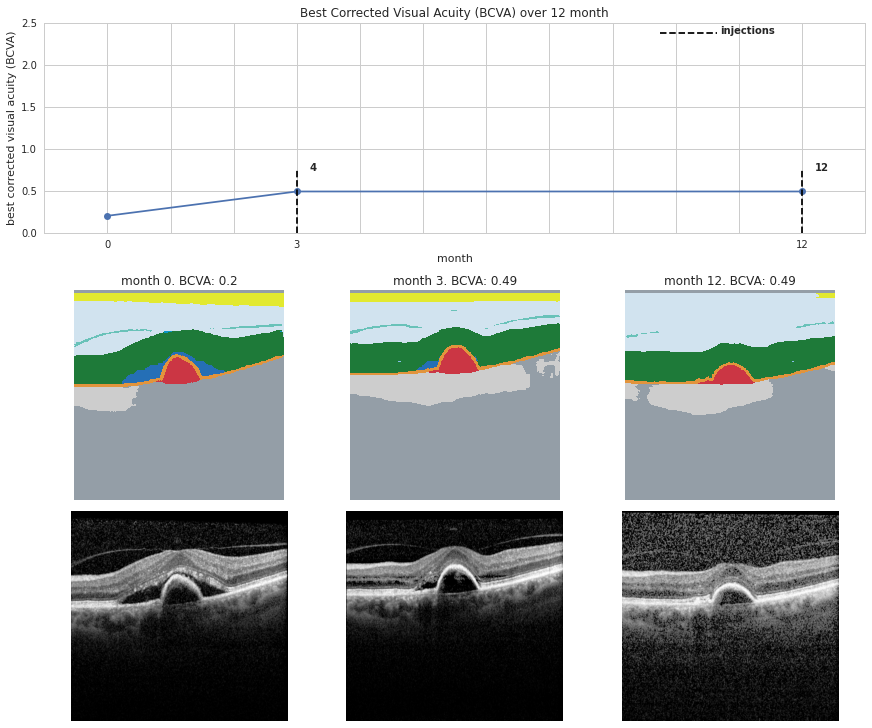

In [90]:
import random

# copy data frame from main & merge with ts characterizations
viz_pd = data_pd.copy()
viz_pd = pd.merge(viz_pd, abt_plt[["seq", "va_3month_improvement"]], 
                  left_on="sequence", right_on="seq", how="left")

# drop not used columns
viz_pd = viz_pd.drop(columns=["Unnamed: 0", "seq"])

# add select columns
viz_pd["case_select_columns"] = None

high_and_strong = (viz_pd.cur_va_rounded_1 > 0.6) & (viz_pd.va_3month_improvement == "strong")
low_and_strong = (viz_pd.cur_va_rounded_1 < 0.6) & (viz_pd.va_3month_improvement == "strong")
high_and_no = (viz_pd.cur_va_rounded_1 > 0.6) & (viz_pd.va_3month_improvement == "no")
low_and_no = (viz_pd.cur_va_rounded_1 < 0.6) & (viz_pd.va_3month_improvement == "no")

viz_pd["case_select_columns"][high_and_strong] = "high_and_strong"
viz_pd["case_select_columns"][low_and_strong]  = "low_and_strong"
viz_pd["case_select_columns"][high_and_no]  = "high_and_no"
viz_pd["case_select_columns"][low_and_no]  = "low_and_no"

# strong, weak, no
TYPE = "low_and_no"
type_filter = viz_pd.case_select_columns == TYPE

type_sequences = viz_pd[type_filter].sequence.tolist()

seq = random.choice(type_sequences)

# get segmentation volume path
case_patient, case_laterality = seq.split("_")

# set case manually
# case_patient = "333250"
# case_laterality = "R"

print("Plotting sequence: ", case_patient, case_laterality)

viz_dict = extract_viz_dict(case_patient=case_patient, case_laterality=case_laterality, data_table=data_pd)
viz_dict = add_image_data_to_dict(viz_dict, SLICE=25)

# plot example
plt.style.use('seaborn-whitegrid')
f = plt.figure(constrained_layout=True, figsize=(12,10))
gs = f.add_gridspec(3, 3)

add_data_panel(f, gs[0,:], viz_dict, title="Best Corrected Visual Acuity (BCVA) over 12 month")
add_image_panels(viz_dict, gs)